# Convolutional Neural Network


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import itertools 
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline




In [5]:
# check GPUs available
physical_device = tf.config.experimental.list_physical_devices('GPU')
print('num of gpus', len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0], True)

num of gpus 0


IndexError: list index out of range

# Data preparation 

#### the images include dogs and cats , and i got it from https://www.kaggle.com/c/dogs-vs-cats/data

In [6]:
# organise the data into train , valid and test directories.
os.chdir('C:/Users/MOKIJ/Desktop/dogs-vs-cats')

if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for c in random.sample(glob.glob('cat*'), 500):
        shutil.move(c,'train/cat' )
    
    for c in random.sample(glob.glob('dog*'), 500):
        shutil.move(c,'train/dog' )
    
    for c in random.sample(glob.glob('cat*'), 100):
        shutil.move(c,'valid/cat' )
    
    for c in random.sample(glob.glob('dog*'), 100):
        shutil.move(c,'valid/dog' )
    
    for c in random.sample(glob.glob('cat*'), 50):
        shutil.move(c,'test/cat' )
    
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.move(c,'test/dog' )
os.chdir('../../')


In [7]:
# get the data from folders for train , valid, test
train_path = 'C:/Users/MOKIJ/Desktop/dogs-vs-cats/train'
valid_path = 'C:/Users/MOKIJ/Desktop/dogs-vs-cats/valid'
test_path = 'C:/Users/MOKIJ/Desktop/dogs-vs-cats/test'

In [8]:
# to make the data into format code be understood when using fit func. using keras generator
# this function is used for preprocessing the images before they get passed to the network -- (vgg16 is popular model)
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory= train_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)
# target size this is the hight and width that we want the cats and dogs being resized to if u want to scale them up or scale them down (to specify them before pass them to the network)  
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory= valid_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)
# calsses is potential labels for the data set 
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory= test_path, target_size=(224,224), classes=['cat','dog'] ,batch_size=10 ,shuffle=False)


Found 1002 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [10]:
#verifing the results really the same 
assert train_batches.n == 1002 
assert valid_batches.n == 500 
assert test_batches.n == 200
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes==2

In [11]:
#this to grab a single batch of images from corresponding from a train batches (it should be 10 batches with 10)
imgs, labels = next(train_batches)

In [12]:
# this function will plot images in the form of a grid with 1 row and 10 columns where images are placed 
def plotImages(image_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(image_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

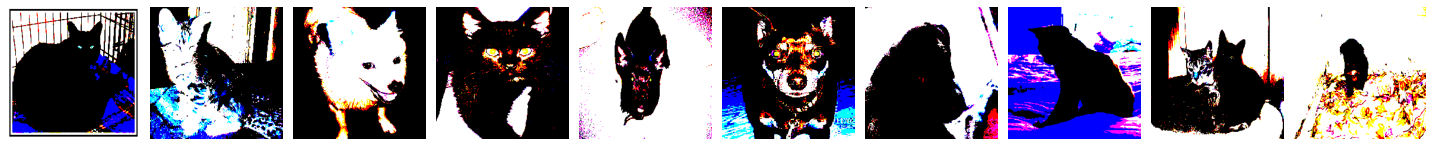

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [13]:
# شكل الصور بهتان نتيجة مرحلة preprocessing the images
# vgg16 model
plotImages(imgs)
print(labels)

In [14]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

# Build and train a CNN

In [17]:
# the CNN nerual network used for images classification
model = Sequential([
    # conv2d is the first hiddin layer 
    # kernel size (3,3) common choice for image data  , padding same  = padding =0 , for the first layer we specify the input shape (224,224), (3) RGB format color chanels   
    Conv2D(filters= 32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    
    Conv2D(filters= 64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    tf.keras.layers.Dense(units=2, activation='softmax'),]) # soft max gives u probability for each coressponding out put from the model 

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [19]:
#compling using adam optimizser
model.compile(optimizer= Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# we spesified x and didnt specify y (which is target data usually) cuz when data stored as a generator as we have here the generator it self has the corresponding labels so we dont need to specify them     , epochs used for how many times it will be processing in the network,  verbose =2 to see the most verbose output during training
model.fit(x=train_batches, validation_data= valid_batches , epochs=10, verbose=2)

Train for 101 steps, validate for 50 steps
Epoch 1/10
101/101 - 47s - loss: 18.9148 - accuracy: 0.5449 - val_loss: 18.1854 - val_accuracy: 0.4660
Epoch 2/10
101/101 - 45s - loss: 3.9871 - accuracy: 0.7285 - val_loss: 3.2999 - val_accuracy: 0.5880
Epoch 3/10
101/101 - 46s - loss: 0.4875 - accuracy: 0.8992 - val_loss: 3.0144 - val_accuracy: 0.6020
Epoch 4/10
101/101 - 49s - loss: 0.1459 - accuracy: 0.9491 - val_loss: 2.9643 - val_accuracy: 0.6160
Epoch 5/10
101/101 - 48s - loss: 0.0354 - accuracy: 0.9870 - val_loss: 2.7350 - val_accuracy: 0.5980
Epoch 6/10
101/101 - 47s - loss: 0.0143 - accuracy: 0.9940 - val_loss: 2.7154 - val_accuracy: 0.5960
Epoch 7/10
101/101 - 51s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.6694 - val_accuracy: 0.6020
Epoch 8/10
101/101 - 53s - loss: 5.2520e-04 - accuracy: 1.0000 - val_loss: 2.6742 - val_accuracy: 0.6000
Epoch 9/10
101/101 - 48s - loss: 4.2420e-04 - accuracy: 1.0000 - val_loss: 2.6762 - val_accuracy: 0.6040
Epoch 10/10
101/101 - 45s - loss: 3.63

# pridect

In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [13]:
test_batches.classes

NameError: name 'test_batches' is not defined

In [ ]:
predictions= model.predict(x=test_batches, verbose=0)

In [ ]:
np.round(predictions)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)) 

In [14]:
 def plot_confusion_matrix(cm, 
                           classes, 
                           normalize=False, 
                           title='Confusion matrix', 
                           cmap= plt.cm.Blues):
    
   # this function prints and plots the confusion matrix.
   # normalization can be applid by setting 'normalize= True'.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
      cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
      print('normalized confusion matrix')
    
    else:
        print('confusion matrix, without normalization')
    
    
    print(cm)
    
    thresh = cm.max()/2
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j,i,cm[i, j],
                horizontalalignment='center',
                color="black" if cm[i,j] > thresh else 'black') 

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')


NameError: name 'plt' is not defined

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels= ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Build Fine-Tuned VGG16 model 

In [15]:
# download model - internet connection needed 
vgg16_model = tf.keras.applications.vgg16.VGG16()

AttributeError: module 'tensorflow.keras' has no attribute 'applications'

In [ ]:
vg = vgg16_model 

In [ ]:
# just for checking if we got the right model 
def count_params(model):
    non_traibale_params = np.sum([np.prod(v.get_shape)])

In [16]:
# just for checking if we got the right model 
params = count_params(vgg_model)
assert params['Non-trainable params'] == 0
assert params['Trainable params'] == 1383557544

NameError: name 'count_params' is not defined

In [ ]:
vg.summary()

In [ ]:
type(vg)

In [ ]:
# this is our model we used VGG16 we took from keras api and changed it abit by removing last line 
# predictions (Dense) 
# by  looping into the model but not the last line thats it
model = Sequential()
for layer in vg.layers[:-1]:
    model.add(layer)

In [17]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
params = count_params(model)
assert params['Non-trainable params'] == 0
assert params['Trainable params'] == 134260544

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.add(Dense(units=2, activation='softmax'))

In [18]:
model.summary()

NameError: name 'model' is not defined

# Train the fine-tuned VGG16 model.

In [ ]:
model.compile(optimizer= Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

NameError: name 'model' is not defined

In [ ]:
assert model.history.history.get('accuracy')[-1] > 0.95

# predict using fint-tuned VGG16 model

In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [20]:
predictions = model.predict(x=test_batches, verbose=0)

NameError: name 'model' is not defined

In [ ]:
test_batches.classes

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)) 

In [21]:
test_batches.class_indices

NameError: name 'test_batches' is not defined

In [ ]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')